## Experimento 1: Transporte determinista (Advección pura)

**Observación visual:**
Al simular las partículas usando solo el vector de viento constante, observamos que todas se mueven formando una línea recta o un punto denso que se desplaza.

**Explicación física:**
En esta etapa, el modelo es puramente **determinista**.
$$\vec{r}_{nuevo} = \vec{r}_{viejo} + \vec{V}_{viento} \cdot dt$$

Como todas las partículas nacen en el mismo punto $(0,0)$ y experimentan exactamente la misma velocidad de viento, no existe ninguna fuerza que las separe entre sí. Matemáticamente, la varianza de la posición es cero. Esto representa un flujo laminar ideal sin turbulencia, lo cual no es realista para una nube volcánica.

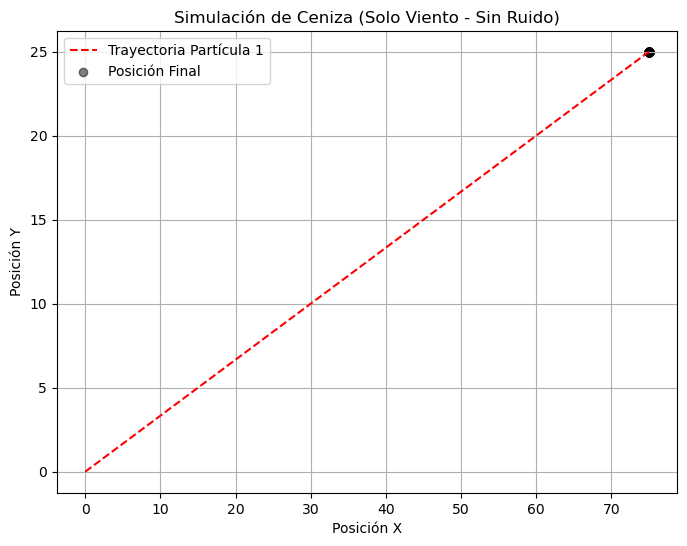

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# --- CONFIGURACIÓN ---
N_PARTICULAS = 100
DT = 1.0          # Paso de tiempo
TIEMPO_TOTAL = 50 # Pasos totales

# --- INICIALIZACIÓN ---
# Crear array de posiciones (N filas, 2 columnas: x, y)
# Todas empiezan en (0,0)
posiciones = np.zeros((N_PARTICULAS, 2))

# Definir viento (velocidad constante en x, y)
viento = np.array([1.5, 0.5]) 

# --- HISTORIAL PARA GRAFICAR ---
# Guardaremos la posición de todas las partículas en cada paso
historial = [posiciones.copy()]

# --- BUCLE DE SIMULACIÓN ---
for t in range(TIEMPO_TOTAL):
    # 1. Mover partículas (Solo advección por viento por ahora)
    # pos_nueva = pos_vieja + (viento * dt)
    posiciones = posiciones + (viento * DT)
    
    # 2. Guardar estado
    historial.append(posiciones.copy())

# --- VISUALIZACIÓN ---
# Convertir historial a array para facilitar el plot
historial = np.array(historial) # Forma: (Pasos, N, 2)

plt.figure(figsize=(8,6))

# Graficar la trayectoria de la primera partícula como ejemplo
plt.plot(historial[:, 0, 0], historial[:, 0, 1], 'r--', label='Trayectoria Partícula 1')

# Graficar la posición FINAL de todas las partículas
# (Como no hay ruido aleatorio aun, todas estarán en el mismo punto)
plt.scatter(historial[-1, :, 0], historial[-1, :, 1], alpha=0.5, c='black', label='Posición Final')

plt.grid(True)
plt.legend()
plt.title("Simulación de Ceniza (Solo Viento - Sin Ruido)")
plt.xlabel("Posición X")
plt.ylabel("Posición Y")
plt.show()

## Experimento 2: Introducción de la turbulencia (Difusión)

**Observación visual:**
Al agregar un término de ruido aleatorio, la línea recta se rompe. Vemos formarse una estructura de "cono" o nube circular que se ensancha a medida que se aleja del origen.

**Explicación física:**
Hemos introducido la estocasticidad (caos) mediante el Movimiento Browniano. Ahora existe una competencia entre dos fuerzas:el viento (quiere llevar todas las partículas juntas hacia adelante) y la difusión ( quiere dispersar las partículas en todas direcciones).

El resultado es que la nube se expande con el tiempo. El ancho de la nube es proporcional a $\sqrt{t}$, lo que explica la forma cónica: al principio están juntas, pero con el tiempo la incertidumbre de su posición crece.

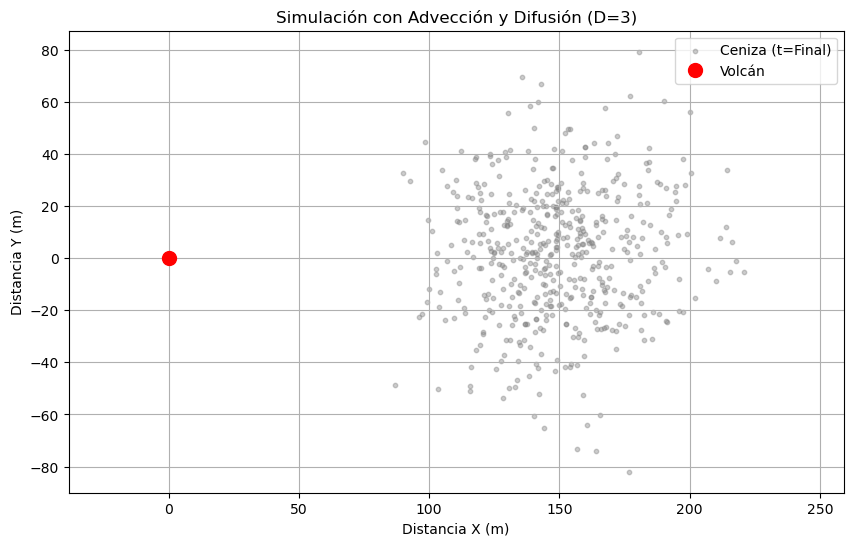

In [ ]:
# --- CONFIGURACIÓN ---
N_PARTICULAS = 500  # <--- AUMENTAMOS ESTO para ver una nube densa
DT = 1.0            
TIEMPO_TOTAL = 100  # Más tiempo para ver la expansión
D = 3         # <--- NUEVO: Coeficiente de Difusión (fuerza de la turbulencia)

# --- INICIALIZACIÓN ---
posiciones = np.zeros((N_PARTICULAS, 2))
viento = np.array([1.5, 0.0]) # Viento hacia la derecha

historial = [posiciones.copy()]

# --- BUCLE DE SIMULACIÓN ---
for t in range(TIEMPO_TOTAL):
    
    # 1. Componente Determinista (El Viento arrastra)
    adveccion = viento * DT
    
    # 2. Componente Estocástica (El Caos)
    # Generamos un empujón aleatorio para CADA partícula
    # La magnitud del ruido escala con la raíz cuadrada del tiempo (std = sqrt(2*D*dt))
    std_dev = np.sqrt(2 * D * DT)
    ruido = np.random.normal(loc=0.0, scale=std_dev, size=(N_PARTICULAS, 2))
    
    # 3. Sumar todo: Nueva Pos = Vieja + Viento + Ruido
    posiciones = posiciones + adveccion + ruido
    
    historial.append(posiciones.copy())

# --- VISUALIZACIÓN ---
historial = np.array(historial) 

plt.figure(figsize=(10,6))

# Graficamos todas las partículas en el paso final
plt.scatter(historial[-1, :, 0], historial[-1, :, 1], 
            alpha=0.4, s=10, c='gray', label='Ceniza (t=Final)')

# Graficamos el punto de origen
plt.plot(0, 0, 'ro', markersize=10, label='Volcán')

plt.grid(True)
plt.legend()
plt.title(f"Simulación con Advección y Difusión (D={D})")
plt.xlabel("Distancia X (m)")
plt.ylabel("Distancia Y (m)")
plt.axis('equal') # Para no deformar la visualización
plt.show()

## Experimento 3: Viento realista

**Observación Visual:**
La nube se deforma diagonalmente.

**Explicación física:**
En la atmósfera real, el viento no es constante. Implementamos un perfil de cizalladura (Wind Shear), donde la velocidad del viento depende de la altura ($y$):
* Las partículas que (por azar) se difundieron hacia arriba, encontraron vientos más fuertes y avanzaron más rápido.
* Las partículas que bajaron, encontraron vientos más suaves y se quedaron rezagadas.

Este fenómeno es crítico en vulcanología: la dispersión de ceniza depende fuertemente de en qué capa de la atmósfera se encuentre la partícula. 

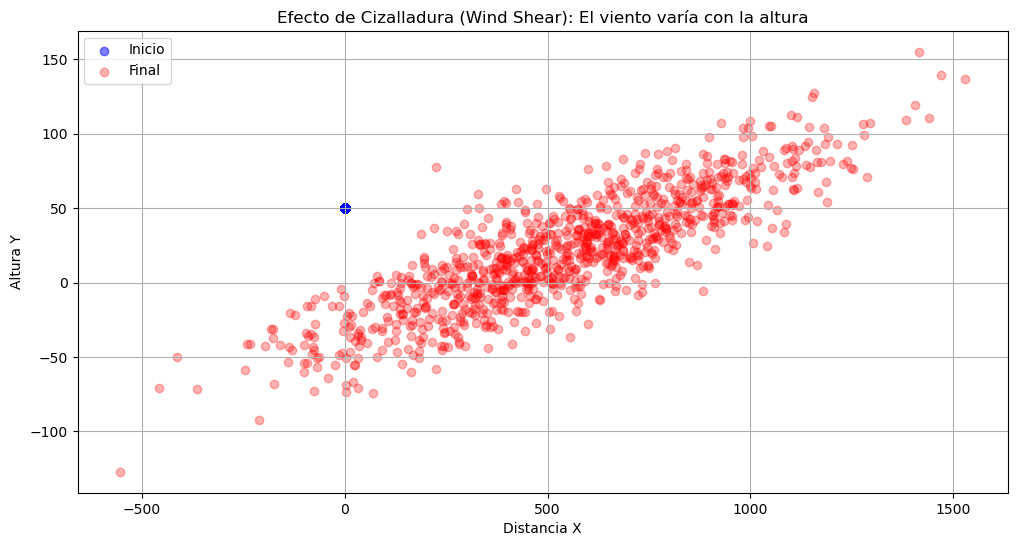

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# --- CONFIGURACIÓN ---
N_PARTICULAS = 1000
DT = 1.0
TIEMPO_TOTAL = 150
D = 5.0 # Difusión

# --- INICIALIZACIÓN ---
# Todas nacen en x=0, y=50 (Altura media para ver cómo el viento varía arriba y abajo)
posiciones = np.zeros((N_PARTICULAS, 2)) + [0.0, 50.0] 
historial = [posiciones.copy()]

# --- FUNCIÓN DE CAMPO DE VIENTO ---
def obtener_viento(posiciones):
    """
    Calcula el vector de viento para cada partícula dependiendo de su altura (y).
    Modelo: 'Wind Shear' (Cizalladura).
    El viento es más fuerte a mayor altura.
    """
    # Extraemos las alturas (columna 1)
    alturas = posiciones[:, 1]
    
    # Velocidad X: Aumenta con la altura (0.1 * altura)
    vx = 0.1 * alturas 
    
    # Velocidad Y: Supongamos que hay una ligera corriente hacia abajo (gravedad/sedimentación)
    vy = np.full(alturas.shape, -0.2) 
    
    # Apilamos vx y vy para tener la forma (N, 2)
    return np.column_stack((vx, vy))

# --- BUCLE DE SIMULACIÓN ---
for t in range(TIEMPO_TOTAL):
    
    # 1. Calcular el viento LOCAL para cada partícula
    viento_local = obtener_viento(posiciones)
    
    # 2. Advección
    adveccion = viento_local * DT
    
    # 3. Difusión (Ruido)
    std_dev = np.sqrt(2 * D * DT)
    ruido = np.random.normal(0, std_dev, size=(N_PARTICULAS, 2))
    
    # 4. Actualizar
    posiciones = posiciones + adveccion + ruido
    historial.append(posiciones.copy())

# --- VISUALIZACIÓN ---
historial = np.array(historial)

plt.figure(figsize=(12,6))

# Graficamos estado inicial (Azul)
plt.scatter(historial[0, :, 0], historial[0, :, 1], c='blue', alpha=0.5, label='Inicio')

# Graficamos estado final (Rojo)
plt.scatter(historial[-1, :, 0], historial[-1, :, 1], c='red', alpha=0.3, label='Final')

plt.title("Efecto de Cizalladura (Wind Shear): El viento varía con la altura")
plt.xlabel("Distancia X")
plt.ylabel("Altura Y")
plt.grid(True)
plt.legend()
plt.show()

## Experimento 4: Condiciones de frontera y topografía

**Observación visual:**
Hasta ahora, nuestras partículas caían al vacío infinito (valores negativos de $y$). En esta fase, introducimos un suelo ($y=0$) y una estructura volcánica.
* Las partículas que tocan el suelo se detienen y cambian de color (simulando ceniza fría depositada).
* El punto de emisión ya no flota en la nada, sino que corresponde a la cima de un cono volcánico de 100m de altura.

**Explicación física:**
En física computacional, un sistema de ecuaciones diferenciales necesita condiciones de frontera (Boundary Conditions) para ser resuelto en un espacio finito.
Hemos implementado una frontera absorbente en el suelo:
1.  **Detección de colisión:** En cada paso, verificamos si la posición $y_i \le 0$.
2.  **Sedimentación:** Si hay colisión, anulamos la velocidad de la partícula y fijamos su posición en $y=0$. Físicamente, esto representa la deposición de material piroclástico que deja de ser transportado por el viento.

**Optimización computacional:**
Para mantener la eficiencia, utilizamos **Máscaras Booleanas** de NumPy. Esto nos permite "apagar" los cálculos de física (viento y ruido) para las partículas que ya están en el suelo, ahorrando recursos computacionales a medida que avanza la simulación.

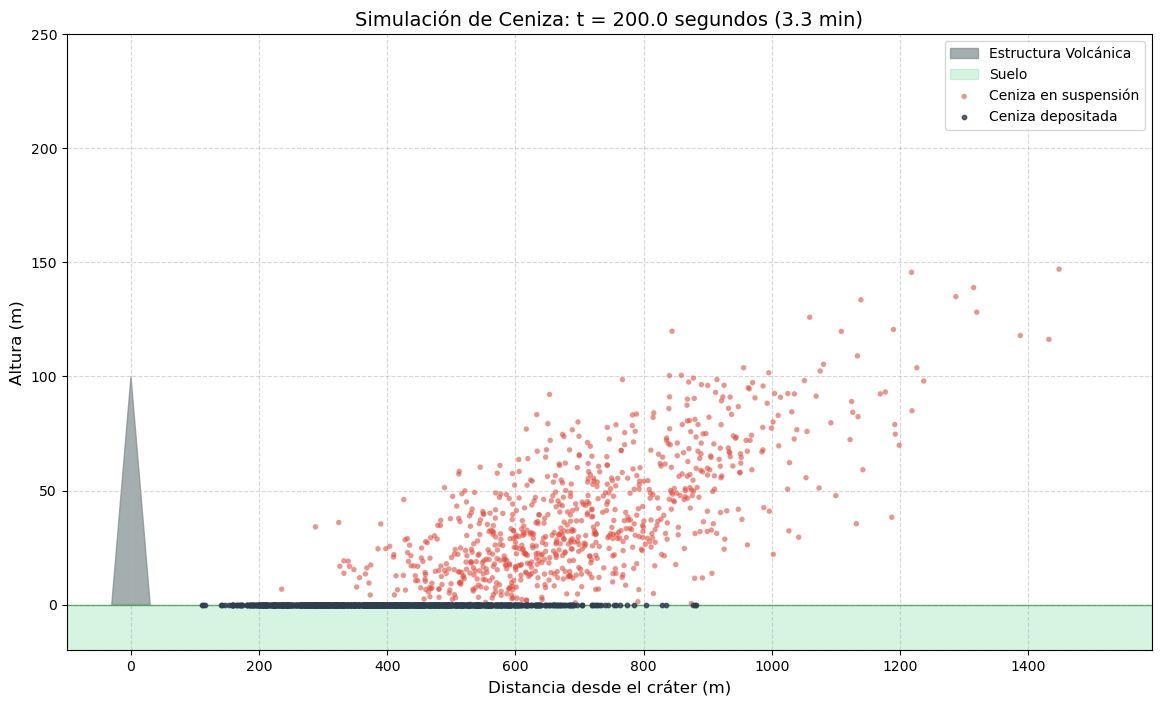

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# --- CONFIGURACIÓN ---
N_PARTICULAS = 2000
DT = 1.0
TIEMPO_TOTAL = 200
D = 5.0 

# --- INICIALIZACIÓN ---
posiciones = np.zeros((N_PARTICULAS, 2)) + [0.0, 100.0] # Empiezan alto (100m)
# Creamos un array para saber quién está "vivo" (en el aire) y quién "muerto" (en el suelo)
# True = Vuela, False = En el suelo
estado_vuelo = np.ones(N_PARTICULAS, dtype=bool) 

historial = [posiciones.copy()]

# --- FUNCIÓN VIENTO ---
def obtener_viento(posiciones):
    alturas = posiciones[:, 1]
    vx = 0.05 * alturas          # Cizalladura
    vy = np.full(alturas.shape, -0.5) # Gravedad/Sedimentación constante hacia abajo
    return np.column_stack((vx, vy))

# --- BUCLE ---
for t in range(TIEMPO_TOTAL):
    
    # SOLO actualizamos las partículas que siguen volando (estado_vuelo == True)
    # Esto ahorra cálculo y congela las que caen.
    
    # 1. Filtramos: solo tomamos las posiciones de las partículas en el aire
    pos_activas = posiciones[estado_vuelo]
    
    if len(pos_activas) > 0: # Solo calculamos si queda alguna volando
        
        # 2. Física (igual que antes)
        viento = obtener_viento(pos_activas)
        adveccion = viento * DT
        
        std_dev = np.sqrt(2 * D * DT)
        ruido = np.random.normal(0, std_dev, size=pos_activas.shape)
        
        # 3. Mover solo las activas
        posiciones[estado_vuelo] += adveccion + ruido
    
    # --- NUEVO: CONDICIÓN DE SUELO ---
    # Revisamos quiénes han cruzado el suelo (y <= 0) en este paso
    en_suelo = posiciones[:, 1] <= 0
    
    # A las que tocaron suelo, corregimos su posición a 0 (para que no queden en -0.5)
    posiciones[en_suelo, 1] = 0.0
    
    # Marcamos esas partículas como "muertas" (False) para que el IF de arriba las ignore en el futuro
    estado_vuelo[en_suelo] = False
    
    # Guardamos historia
    historial.append(posiciones.copy())

# --- VISUALIZACIÓN MEJORADA ---
historial = np.array(historial)

# Configuración de la figura
plt.figure(figsize=(14, 8))
ax = plt.gca() # Obtenemos el eje actual para dibujar formas

# 1. DIBUJAR EL VOLCÁN (Contexto visual)
# Un triángulo simple: Base izquierda, Cima (0, 100), Base derecha
altura_volcan = 100
ancho_base = 60
volcan_x = [-ancho_base/2, 0, ancho_base/2]
volcan_y = [0, altura_volcan, 0]
ax.fill(volcan_x, volcan_y, color='#7f8c8d', alpha=0.7, label='Estructura Volcánica', zorder=1)

# 2. DIBUJAR EL SUELO
# Usamos un relleno verde suave en lugar de una línea dura oscura
plt.axhspan(-20, 0, color='#2ecc71', alpha=0.2, label='Suelo', zorder=0)
plt.axhline(0, color='green', linewidth=1, alpha=0.5)

# 3. DIBUJAR LAS PARTÍCULAS
final_x = historial[-1, :, 0]
final_y = historial[-1, :, 1]

# Identificamos cuáles vuelan y cuáles cayeron
vivas = final_y > 0

# Partículas en el aire (Rojo/Naranja volcánico)
plt.scatter(final_x[vivas], final_y[vivas], 
            c='#e74c3c', s=15, alpha=0.6, edgecolors='none', label='Ceniza en suspensión', zorder=3)

# Partículas en el suelo (Gris oscuro / Ceniza fría)
plt.scatter(final_x[~vivas], final_y[~vivas], 
            c='#2c3e50', s=10, alpha=0.8, label='Ceniza depositada', zorder=3)

# 4. TEXTOS Y DETALLES
tiempo_total_segundos = TIEMPO_TOTAL * DT
plt.title(f"Simulación de Ceniza: t = {tiempo_total_segundos} segundos ({tiempo_total_segundos/60:.1f} min)", fontsize=14)
plt.xlabel("Distancia desde el cráter (m)", fontsize=12)
plt.ylabel("Altura (m)", fontsize=12)
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.5)

# Ajustar límites para ver bien todo
plt.xlim(-100, max(final_x)*1.1) # Un poco de margen a la derecha
plt.ylim(-20, 250) # Margen arriba y abajo

plt.show()